# Transfer learning with TensorFlow part 1 : Feature extraction
There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
# Are we using a GPU
!nvidia-smi

Tue Dec 27 13:02:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with the data

In [2]:
# Get 10 percent of ten food classes from Food101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close

--2022-12-27 13:02:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.3MB/s    in 8.7s    

2022-12-27 13:02:47 (18.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of file
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in ' {dirpath} '.")

There are 2 directories and 0 images in ' 10_food_classes_10_percent '.
There are 10 directories and 0 images in ' 10_food_classes_10_percent/test '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/steak '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/ice_cream '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/hamburger '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/chicken_wings '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/chicken_curry '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/pizza '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/grilled_salmon '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/ramen '.
There are 0 directories and 250 images in ' 10_food_classes_10_percent/test/sushi '.
There are 0 directories and 250 images in ' 10_food_

## Creating data loaders (preparing the data)
we will use the ImageDataGenerator Class to load in our data

In [10]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size = IMAGE_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = "categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")


Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up call backs (things to run whilst our model trains)
callbacks are extra functionality you can add to your mdoels
to be performed during or after training Some of the most popular callabacks are:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callbacks 

In [19]:
#  Create tensorboard call back and functionize it
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return(tensorboard_callback)

## Creating model using tensorflow hub
In the past we have used tensor flow to write our models line by line.
Now we are going to do a similar process except the majority of our model layers are going to come from tensorflow hub.

We can access  pretrained models on https://tfhub.dev/

Resnet https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5

Efficient net https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [12]:
# Lets compare following two models
resnet_url ="https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"
efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [13]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return (model)

### Creating and testing Resnet model

In [15]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile Our Resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221227-1325
Epoch 1/5
24/24 [==============================] - 42s 1s/step - loss: 1.7376 - accuracy: 0.4440 - val_loss: 1.0506 - val_accuracy: 0.6536
Epoch 2/5
24/24 [==============================] - 23s 992ms/step - loss: 0.7716 - accuracy: 0.7320 - val_loss: 0.7572 - val_accuracy: 0.7568
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.5275 - accuracy: 0.8373 - val_loss: 0.6902 - val_accuracy: 0.7724
Epoch 4/5
24/24 [==============================] - 23s 981ms/step - loss: 0.4010 - accuracy: 0.9027 - val_loss: 0.6372 - val_accuracy: 0.7952
Epoch 5/5
24/24 [==============================] - 23s 987ms/step - loss: 0.3071 - accuracy: 0.9413 - val_loss: 0.6389 - val_accuracy: 0.7884


In [21]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

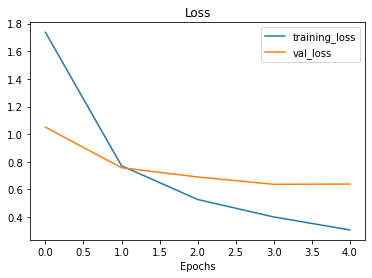

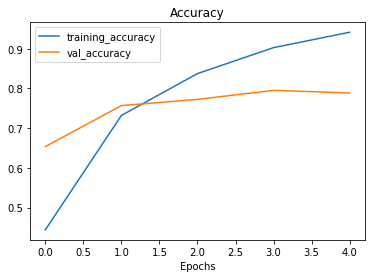

In [22]:
plot_loss_curves(resnet_history)

In [23]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             58331648  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 58,352,138
Trainable params: 20,490
Non-trainable params: 58,331,648
_________________________________________________________________


## Creatring Efficient Net Model

In [24]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])
     

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221227-1333
Epoch 1/5
24/24 [==============================] - 26s 740ms/step - loss: 1.8112 - accuracy: 0.4747 - val_loss: 1.2608 - val_accuracy: 0.7460
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 1.0373 - accuracy: 0.7667 - val_loss: 0.8459 - val_accuracy: 0.8292
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.7382 - accuracy: 0.8320 - val_loss: 0.6851 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 17s 712ms/step - loss: 0.5942 - accuracy: 0.8547 - val_loss: 0.5990 - val_accuracy: 0.8644
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.5012 - accuracy: 0.8907 - val_loss: 0.5512 - val_accuracy: 0.8648


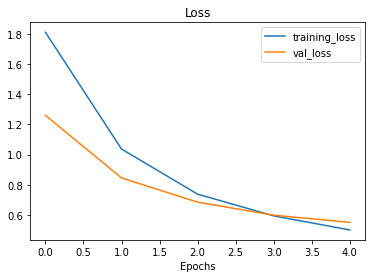

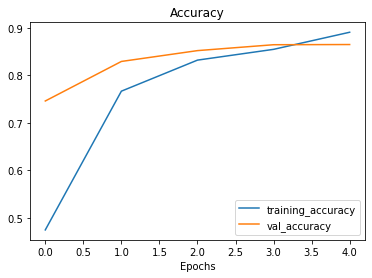

In [25]:
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing models using Tensor Board

In [27]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=9wvsLX21zRnmV5wSzXAnw46tRuXJbK&prompt=consent&access_type=off

## Listing Experiments saved to Tensorboard

In [28]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/kFPxlQuVTGabKQBIMh6nvw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   kFPxlQuVTGabKQBIMh6nvw
	Created              2022-12-27 13:44:59 (2 minutes ago)
	Updated              2022-12-27 13:45:04 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  9149181
Total: 1 experiment(s)


## Deleting experiments from TensorBoard

In [30]:
# Delete an experiment
!tensorboard dev delete --experiment_id kFPxlQuVTGabKQBIMh6nvw

Deleted experiment kFPxlQuVTGabKQBIMh6nvw.


In [31]:
# Check to see if experiments still exist
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
